In [1]:
import pandas as pd
import numpy as np
import os

from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
%matplotlib inline

from math import ceil
from statistics import mean

import re
#################################
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

#################################

import sys

sys.path.append('../model_0')
from model import NNModelEx

In [2]:
# if data needs to be re-generated, rerun this cell
# this are globals
all_data = None
sampled_data = None

In [3]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, inp, tgt, device='cpu'):
        'Initialization'
        self.inp = to_device(torch.from_numpy(inp).float(), device)
        self.tgt = to_device(torch.from_numpy(tgt).float(), device)
        self.num_X = inp.shape[1]
        self.num_y = tgt.shape[1]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.tgt)

    def __getitem__(self, index):
        'Generates one sample of data'
        return self.inp[index], self.tgt[index]

In [4]:
def get_ref_X_y(df):
    ref_cols = [c for c in df.columns if c.startswith('__')]
    X_cols = [c for c in df.columns if c.startswith('X_')]
    y_cols = [c for c in df.columns if c.startswith('y_')]
    return (df[ref_cols], df[X_cols], df[y_cols])

In [5]:
def load_and_scale_data(ignore_cols=[], prefix=""):
    train_df = pd.read_pickle(f"{os.environ['GP_HIST_PATH']}/../t0_data/{prefix}train.pkl")
    test_df = pd.read_pickle(f"{os.environ['GP_HIST_PATH']}/../t0_data/{prefix}test.pkl")
    
    # move columns from X or y to ref
    ignore_dict = {x:re.sub('^.', '_', x, 1) for x in ignore_cols}
    train_df = train_df.rename(columns=ignore_dict)
    test_df = test_df.rename(columns=ignore_dict)
    
    ref_train, X_train, y_train = get_ref_X_y(train_df)
    ref_test, X_test, y_test = get_ref_X_y(test_df)

    X_min_max_scaler = MinMaxScaler()
    y_min_max_scaler = MinMaxScaler()

    X_train = X_min_max_scaler.fit_transform(X_train)
    y_train = y_min_max_scaler.fit_transform(y_train)
    X_test = X_min_max_scaler.fit_transform(X_test)
    y_test = y_min_max_scaler.fit_transform(y_test)
    
    return train_df, test_df, X_min_max_scaler, y_min_max_scaler, ref_train, X_train, y_train, ref_test, X_test, y_test

In [6]:
def load_data_with_config(config):
    # kinda lazy here so using global to avoid reloading the datasets
    global sampled_data, all_data
    if config['use_sampled'] == True:
        if sampled_data == None:
            print("Loading sampled data")
            sampled_data = load_and_scale_data(prefix = "sample_")
        return sampled_data
    else:
        if all_data == None:
            print("Loading all data")
            all_data = load_and_scale_data()
        return all_data
    
def load_model_with_config(config):
    # a bit hacky, but in the training phase, we never load and use the minmax scalers
    # just putting it here for when we want to load the model elsewhere THEN revert scaling
    # probably better to have the scalers saved separately....

    f = f"{os.environ['GP_HIST_PATH']}/../t0_models/{config['model_identifier']}.pth"
    if os.path.exists(f):
        print("Loading existing model")
        checkpoint = torch.load(f)
        net = checkpoint['net']
        loss_func = checkpoint['loss_func']
        optimizer = checkpoint['optimizer']
        mean_losses = checkpoint['mean_losses']
        all_losses = checkpoint['all_losses']
        next_epoch = checkpoint['next_epoch']
        X_min_max_scaler = checkpoint['X_min_max_scaler']
        y_min_max_scaler = checkpoint['y_min_max_scaler']
    else:
        print("New model created")
        net = NNModelEx(inputSize=training_set.num_X, outputSize=training_set.num_y, **config['model_definition'])
        loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
        optimizer = torch.optim.Adam(net.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
        mean_losses = []
        all_losses = []
        next_epoch = 0
        save_model_with_config(config, net=net, loss_func=loss_func, optimizer=optimizer,
                               mean_losses=mean_losses, all_losses=all_losses, next_epoch=next_epoch,
                               X_min_max_scaler=None, y_min_max_scaler=None,
                              )
        # blank scaler when creating new model
        X_min_max_scaler = None
        y_min_max_scaler = None
    return net, loss_func, optimizer, mean_losses, all_losses, next_epoch, X_min_max_scaler, y_min_max_scaler

def save_model_with_config(config, **kwargs):
    f = f"{os.environ['GP_HIST_PATH']}/../t0_models/{config['model_identifier']}.pth"
    torch.save(kwargs, f)

In [7]:
# SAMPLED DATA
configurations = {
    'model_identifier' : "sample_6",
    'use_sampled' : True,
    'random_seed' : 0,
    'lr' : 1e-5,
    'weight_decay' : 1e-6,
    'max_epochs' : 100,
    'do_validate' : True,
    'model_definition' : {
        'layer_1': 100, 'relu__1': True, 'drop__1': 0.7,
        'layer_2': 100, 'relu__2': True, 'drop__2': 0.7,
        'layer_3': 100, 'relu__3': True, 'drop__3': 0.7,
        'layer_4': 50,  'relu__4': True, 'drop__4': 0.7,
        'layer_5': 50,  'relu__5': True, 'drop__5': 0.4,
        'layer_6': 50,  'relu__6': True, 'drop__6': 0.4,
        'layer_7': 50,  'relu__7': True, 'drop__7': 0.4,
        'layer_8': 50,  'relu__8': True, 'drop__8': 0.4,
    },
    'train_params' : {
        'batch_size': 1000,
        'shuffle': True,
        'num_workers': 2,
    },
    'test_params' : {
        'batch_size': 20000,
        'num_workers': 2,
    },
}

# # ALL DATA
# configurations = {
#     'model_identifier' : "full_dataset_3",
#     'use_sampled' : False,
#     'random_seed' : 0,
#     'lr' : 1e-5,
#     'weight_decay' : 1e-6,
#     'max_epochs' : 5,
#     'do_validate' : True,
#     'model_definition' : {
#         'layer_1': 100, 'relu__1': True, 'drop__1': 0.7,
#         'layer_2': 100, 'relu__2': True, 'drop__2': 0.7,
#         'layer_3': 100, 'relu__3': True, 'drop__3': 0.7,
#         'layer_4': 100, 'relu__4': True, 'drop__4': 0.7,
#         'layer_5': 100, 'relu__5': True, 'drop__5': 0.7,
#         'layer_6': 100, 'relu__6': True, 'drop__6': 0.7,
#         'layer_7': 100, 'relu__7': True, 'drop__7': 0.7,
#     },
#     'train_params' : {
#         'batch_size': 10000,
#         'shuffle': True,
#         'num_workers': 6,
#     },
#     'test_params' : {
#         'batch_size': 200000,
#         'num_workers': 6,
#     },
# }

In [9]:
# data and base config
train_df, test_df, X_min_max_scaler, y_min_max_scaler, \
 ref_train, X_train, y_train, ref_test, X_test, y_test = load_data_with_config(configurations)
print("Creating Dataset and Dataloader")
training_set = Dataset(X_train, y_train)
training_generator = torch.utils.data.DataLoader(training_set, **configurations['train_params'])
testing_set = Dataset(X_test, y_test)
testing_generator = torch.utils.data.DataLoader(testing_set, **configurations['test_params'])
torch.manual_seed(configurations['random_seed'])

# model, loss, optimizer, and loss history
net, loss_func, optimizer, mean_losses, all_losses, next_epoch, _, _ = load_model_with_config(configurations)
print(net)
print(f"This model has prevoiusly been trained for {next_epoch} of {configurations['max_epochs']} epochs")

# train the network
epbar = tqdm(range(next_epoch, configurations['max_epochs']))
for epoch in epbar:
    net.train()
    epbar.set_description(f"Epoch {epoch+1}")

    elosses = []
    vlosses = []

    ipbar = tqdm(training_generator, leave=False)
    ipbar.set_description(f"Training")
    
    for i, (x, y) in enumerate(ipbar):
        optimizer.zero_grad()
        prediction = net(x)     # input x and predict based on x
        loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
        elosses.append(loss.data.numpy().item())
        ipbar.set_postfix({'loss': loss.data.numpy()})

    mean_vlosses = 0
    if configurations['do_validate']:
        net.eval()
        with torch.set_grad_enabled(False):
            vpbar = tqdm(testing_generator, leave=False)
            vpbar.set_description("Validating")
            for i, (x, y) in enumerate(vpbar):
                prediction = net(x)
                loss = loss_func(prediction, y)
                vlosses.append(loss.data.numpy().item())
                vpbar.set_postfix({'loss': loss.data.numpy()})
        mean_vlosses = mean(vlosses)
            
    mean_elosses = mean(elosses)
    mean_losses.append((mean_elosses, mean_vlosses))
    all_losses.append((elosses, vlosses))
    save_model_with_config(configurations, net=net, loss_func=loss_func, optimizer=optimizer,
                           mean_losses=mean_losses, all_losses=all_losses, next_epoch=epoch+1,
                           X_min_max_scaler=X_min_max_scaler, y_min_max_scaler=y_min_max_scaler,
                          )
    
    epbar.set_postfix({'train_loss':f"{mean_elosses:.9f}", 'val_loss':f"{mean_vlosses:.9f}"})

Creating Dataset and Dataloader
Loading existing model
NNModelEx(
  (net): Sequential(
    (0): Linear(in_features=22, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.7, inplace=False)
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.7, inplace=False)
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.7, inplace=False)
    (9): Linear(in_features=100, out_features=50, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.7, inplace=False)
    (12): Linear(in_features=50, out_features=50, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.4, inplace=False)
    (15): Linear(in_features=50, out_features=50, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.4, inplace=False)
    (18): Linear(in_features=50, out_features=50, bias=True)
    (19): ReLU()
    (20): Dropout(p=0.4, inplace=False)
    (21): Linear(in_features=50, out_features=50, bias=True)
    (22): ReLU()
    (23): Dro

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2846 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

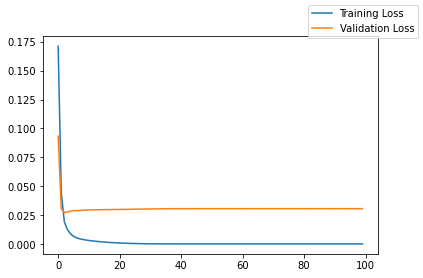

In [10]:
tl, vl = zip(*mean_losses)

fig,ax = plt.subplots()
ax.plot(tl, label="Training Loss")
ax.plot(vl, label="Validation Loss")

fig.legend()
plt.show()